In [1]:
from Function_Definition import *

In [2]:
# Load the data and split them into two classes
data = np.loadtxt("covertype_normalized_csv.csv", delimiter = ",")
data[np.where(data[:,54] != 2)[0], 54] = 1
data[np.where(data[:,54] == 2)[0], 54] = -1
label = data[:,54]
data = data[:,0:54]

In [3]:
# Pick a subset of 5000 data points
train_data_size = 5000
train_label = label[0:train_data_size]
train_data = data[0:train_data_size, :]

In [4]:
test_data_size = 6000
test_label = label[train_data_size+3000: train_data_size+3000+test_data_size]
test_data = data[train_data_size+3000: train_data_size+3000+test_data_size, :]

In [5]:
# Define hyper parameters
squared_sigma = (10)**2
K = gram_matrix_calculation(train_data, 'Gaussian', squared_sigma)
problem = kernel_logistic_regression(lamb = 1e-5)

num_rf = train_data_size * (0.1)
num_sub_newton = train_data_size * (0.1)
mu = 1e-4
bfgs_m = 50

In [46]:
# Compare the test-errors from three model: Full kernel Newton, RFN (our method), RF_transformed with Newton
#initial_w = np.random.multivariate_normal(np.zeros(train_data.shape[0]), (1)*np.eye(train_data.shape[0]), 1)
#initial_w = np.squeeze(initial_w, axis=0)
initial_w = np.zeros(train_data.shape[0])

num_itera = 100


#First model
w1s, results_Newton = Newton_solver(K, train_label, problem, num_itera, initial_w)
w_Newton_solver = w1s[len(w1s)-1]


#Second model
w2s, results_RFN_il = RFN_inversion_lemma(K, train_data, train_label, num_rf, problem, mu, squared_sigma, num_itera, initial_w)
w_RFN_il = w2s[len(w2s)-1]


#Third model
num_rf = int(num_rf)
RF_matrix, w_rf, b_rf = gram_matrix_approximating(train_data, 'Gaussian', num_rf, squared_sigma)
#initial_w2 = np.random.multivariate_normal(np.zeros(RF_matrix.shape[1]), (1)*np.eye(RF_matrix.shape[1]), 1)
#initial_w2 = np.squeeze(initial_w2, axis=0)
initial_w2 = np.zeros(RF_matrix.shape[1])


w3s, results_reviewer = Newton_solver_rf(RF_matrix, train_label, problem, num_itera, initial_w2)
w_reviewer = w3s[len(w3s)-1]


0.6931471805599454
0.3144830966467113
0.3091135509514623
0.3091040917376018
0.30910409144528583
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.3091040914452859
0.309104091

In [44]:
test_data_size = 3000
test_label = label[train_data_size+3000: train_data_size+3000+test_data_size]
test_data = data[train_data_size+3000: train_data_size+3000+test_data_size, :]

In [48]:
test_data = train_data
test_label = train_label

In [49]:

embedding_representation = np.zeros((test_data.shape[0], train_data.shape[0]))

for i in range(test_data.shape[0]):
    embedding_representation[i, :] = np.sum((test_data[i,:]-train_data)**2, axis=1)
embedding_representation = np.exp(-squared_sigma*embedding_representation/(2))

output = 1/(1+np.exp(-np.dot(embedding_representation, w_Newton_solver)))
output[np.where(output >= 0.5)[0]] = 1
output[np.where(output < 0.5)[0]] = -1
output = np.multiply(output, test_label)
test_error1 = np.count_nonzero(output == 1)/output.size
print("Test Error 1: ",test_error1)

output = 1/(1+np.exp(-np.dot(embedding_representation, w_RFN_il)))
output[np.where(output >= 0.5)[0]] = 1
output[np.where(output < 0.5)[0]] = -1
output = np.multiply(output, test_label)
test_error2 = np.count_nonzero(output == 1)/output.size
print("Test Error 2: ",test_error2)

embedding_representation = np.sqrt(2.0/num_rf)*np.cos(np.dot(test_data, w_rf.T)+b_rf)
output = 1/(1+np.exp(-np.dot(embedding_representation, w_reviewer)))
output[np.where(output >= 0.5)[0]] = 1
output[np.where(output < 0.5)[0]] = -1
output = np.multiply(output, test_label)
test_error3 = np.count_nonzero(output == 1)/output.size

print("Test Error 3: ",test_error3)

#print("Test error 1: ", test_error1, "Test error 2: ", test_error2, "Test error 3", test_error3)

Test Error 1:  1.0
Test Error 2:  1.0
Test Error 3:  0.6382


In [5]:
num_trial = 10
num_itera = 80

Newton_all_loss = np.zeros((num_trial, num_itera+1))
Newton_all_time = np.zeros((num_trial, num_itera+1))

LBFGS_all_loss = np.zeros((num_trial, num_itera+1))
LBFGS_all_time = np.zeros((num_trial, num_itera+1))

RFN_all_loss = np.zeros((num_trial, num_itera+1))
RFN_all_time = np.zeros((num_trial, num_itera+1))

SSNCG_all_loss = np.zeros((num_trial, num_itera+1))
SSNCG_all_time = np.zeros((num_trial, num_itera+1))


for i in range(num_trial):
    initial_w = np.random.multivariate_normal(np.zeros(train_data.shape[0]), (1)*np.eye(train_data.shape[0]), 1)
    initial_w = np.squeeze(initial_w, axis=0)

    w1s, results_Newton = Newton_solver(K, train_label, problem, num_itera, initial_w)
    Newton_all_loss[i,:] = results_Newton['l']
    Newton_all_time[i,:] = results_Newton['t']
    
    w2s, results_LBFGS = LBFGS_solver(K, train_label, problem, bfgs_m, num_itera, initial_w)
    LBFGS_all_loss[i,:] = results_LBFGS['l']
    LBFGS_all_time[i,:] = results_LBFGS['t']
    
    w3s, results_SSNCG = SSN_uniform_CG(K, train_label, num_sub_newton, problem, mu, num_itera, initial_w)
    SSNCG_all_loss[i,:] = results_SSNCG['l']
    SSNCG_all_time[i,:] = results_SSNCG['t']
    
    w4s, results_RFN_il = RFN_inversion_lemma(K, train_data, train_label, num_rf, problem, mu, squared_sigma, num_itera, initial_w)
    RFN_all_loss[i,:] = results_RFN_il['l']
    RFN_all_time[i,:] = results_RFN_il['t']
    

1.690291738334869
0.4684869906195495
0.3379531433876635
0.27989326309857004
0.2603864803681325
0.26038242110062715
0.2603811540150658
0.26033217526823255
0.26032532882514703
0.2603161138650357
0.2601893410132097
0.2601807062421716
0.2601782172917864
0.26017647331815913
0.26017637519047393
0.2601369037529809
0.260109540560556
0.2601050108184503
0.26010498758701395
0.26010035611749255
0.2600792643317524
0.26007334311298086
0.26007334069782306
0.2600649072773404
0.25998314316749677
0.259983139525765
0.2599772705537432
0.259976868661999
0.25997485306408874
0.2599695643651051
0.2599599092962817
0.25994474660827716
0.25992462210101475
0.25986151627024595
0.25985392091097825
0.2597854748593929
0.2597854690631648
0.2597762022772371
0.25966550336052135
0.25966137941872985
0.25966133538252245
0.25965751497307094
0.2596431070516975
0.2596419318671196
0.2596344772558079
0.2596293514852145
0.25961828165710743
0.25961274342887763
0.2596008493845341
0.25957148649245065
0.25957087194171674
0.259569918

In [6]:
Newton_all_loss_std = np.std(Newton_all_loss, axis=0)/np.sqrt(Newton_all_loss.shape[0])
Newton_all_time_std = np.std(Newton_all_time, axis=0)/np.sqrt(Newton_all_loss.shape[0])

LBFGS_all_loss_std = np.std(LBFGS_all_loss, axis=0)/np.sqrt(Newton_all_loss.shape[0])
LBFGS_all_time_std = np.std(LBFGS_all_time, axis=0)/np.sqrt(Newton_all_loss.shape[0])

RFN_all_loss_std = np.std(RFN_all_loss, axis=0)/np.sqrt(Newton_all_loss.shape[0])
RFN_all_time_std = np.std(RFN_all_time, axis=0)/np.sqrt(Newton_all_loss.shape[0])

SSNCG_all_loss_std = np.std(SSNCG_all_loss, axis=0)/np.sqrt(Newton_all_loss.shape[0])
SSNCG_all_time_std = np.std(SSNCG_all_time, axis=0)/np.sqrt(Newton_all_loss.shape[0])

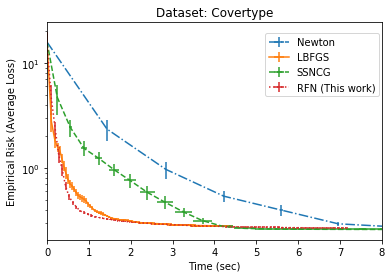

In [7]:
plt.errorbar(np.mean(Newton_all_time, axis=0), np.mean(Newton_all_loss, axis=0), \
             yerr=Newton_all_loss_std, xerr=Newton_all_time_std, ls="-.", label="Newton")

plt.errorbar(np.mean(LBFGS_all_time, axis=0), np.mean(LBFGS_all_loss, axis=0), \
             yerr=LBFGS_all_loss_std, xerr=LBFGS_all_time_std, ls="-", label="LBFGS")

plt.errorbar(np.mean(SSNCG_all_time, axis=0), np.mean(SSNCG_all_loss, axis=0), \
             yerr=SSNCG_all_loss_std, xerr=SSNCG_all_time_std,ls="--", label="SSNCG")

plt.errorbar(np.mean(RFN_all_time, axis=0), np.mean(RFN_all_loss, axis=0), \
             yerr=RFN_all_loss_std, xerr=RFN_all_time_std,ls=":",  label="RFN (This work)")

plt.legend(bbox_to_anchor=(0.65, 0.95), loc='upper left', borderaxespad=0.)

plt.yscale('log') 
plt.xlim(0, 8)
plt.xlabel("Time (sec)")
plt.ylabel("Empirical Risk (Average Loss)")
plt.title('Dataset: Covertype')

plt.show()